# CASA Summary
The pipeline used for calibration and flagging closely follows that of the CASA pipeline (https://casaguides.nrao.edu/index.php?title=VLA-S-CASA_Pipeline-CASA6.2.1#Stage_7._hifv_checkflag:_Flag_possible_RFI_on_BP_calibrator_using_rflag). This notebook summarises the output of the pipeline (calibration tables, flagging summaries, data plots) and can be used to get an overview of the data and identify bad data that needs to be flagged manually.

In [1]:
import os
import sys
import h5py
import yaml
import casatasks
import numpy as np
from astropy.time import Time
import astropy.units as u
from ipywidgets import interact

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib as mpl

cmap = mpl.cm.viridis  
cmap.set_bad(color='red')

from IPython.display import Image

# read yaml file
with open("../input/config.yaml", "r") as file:
    conf = yaml.safe_load(file)
    
sys.path.append(os.path.join(os.curdir, "../"))

from vlapy import vladata, inspect

## Obervation Information 
The data below is the output of CASA's listobs task and can be used to fill in the yaml file "obs.yaml", which contains all the parameters for the pipeline.

In [2]:
obs = conf["obs list"][0]
root = os.path.join(conf["root"], f"{obs}")
name = obs.split(".")[0]

ms = os.path.join(root, f"{obs}_hanning.ms")
vladata.listobs(ms)

BeginTime
58744.51180555556 

EndTime
58744.537152777775 

IntegrationTime
2190.0 

field_0
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': 1.4948845339}, 'm1': {'unit': 'rad', 'value': 0.8700817014000001}, 'refer': 'J2000', 'type': 'direction'}
name :  J0542+4951


field_1
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': 2.7622531831}, 'm1': {'unit': 'rad', 'value': 0.7202694229000001}, 'refer': 'J2000', 'type': 'direction'}
name :  J1033+4116


field_2
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': 2.8307109711}, 'm1': {'unit': 'rad', 'value': 0.8137042526}, 'refer': 'J2000', 'type': 'direction'}
name :  QSO J1048+4637


field_3
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': 3.0145677806}, 'm1': {'unit': 'rad', 'value': 0.6676783576000002}, 'refer': 'J2000', 'type': 'direction'}
name :  J1130+3815


field_4
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': 3.0425255836}, 'm1': {'unit': 'rad', 'value': 0.6253943770000001}, 'refer': 'J20

### Array Layout

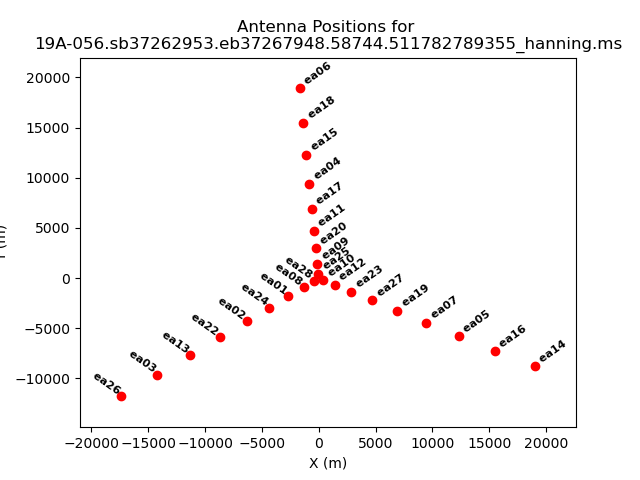

In [3]:
Image(filename=root + "/plots/obsplots/antlayout.png")

### Plot Elevation vs. Time
Observations low in elevation might see more RFI. The plot is colorised by field. Each target field is in between two phase calibrators.

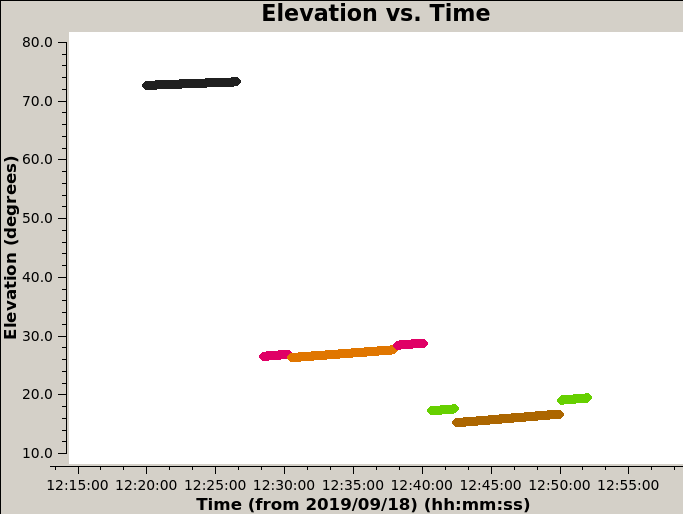

In [4]:
Image(filename=root + "/plots/obsplots/elevation_vs_time.png")

## VLA Deterministic Flags and Manual Flags
These include antennas not on source, shadowed antennas, scans with non-relevant intents, autocorrelations, edge channels of spectral windows, edge channels of the baseband, clipping absolute zero values produced by the correlator and the first few integrations of a scan (quacking). Manual flags are also applied for data known to be bad (RFI, obs reports). Below is a summary of the flags before and after applying the deterministic flags. Use the flagging frequency to find a suitable reference antenna and specify it in the yaml file.

In [5]:
summary_before = np.load(root + "/output/detflag_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + "/output/detflag_summary_after.npy", allow_pickle='TRUE').item()

# print flagging summary
def print_summary(item):
    for subitem in summary_before[item]:
        print(f"{item} {subitem}")
        print(
            "Before: {:.4f}, After: {:.4f}".format(
                100.0 * summary_before[item][subitem]["flagged"] / summary_before[item][subitem]["total"],
                100.0 * summary_after[item][subitem]["flagged"] / summary_after[item][subitem]["total"],
            )
        )
        print("")
        
print("Flag occupancy (percent) before and after deterministic flags:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after deterministic flags:

field J0542+4951
Before: 22.6119, After: 38.1347

field J1033+4116
Before: 39.4121, After: 51.6090

field J1130+3815
Before: 17.1148, After: 33.7531

field QSO J1048+4637
Before: 5.6538, After: 24.5764

field QSO J1137+3549
Before: 4.7783, After: 23.8656

scan 1
Before: 100.0000, After: 100.0000

scan 2
Before: 13.5074, After: 30.8565

scan 3
Before: 54.9723, After: 64.1065

scan 4
Before: 5.6538, After: 24.5764

scan 5
Before: 12.1253, After: 29.6930

scan 6
Before: 25.3254, After: 40.3328

scan 7
Before: 4.7783, After: 23.8656

scan 8
Before: 7.8778, After: 26.3509

antenna ea01
Before: 16.6574, After: 28.0485

antenna ea02
Before: 16.8296, After: 28.1968

antenna ea03
Before: 17.0199, After: 28.3492

antenna ea04
Before: 16.8531, After: 28.2124

antenna ea05
Before: 16.9790, After: 28.3174

antenna ea06
Before: 17.0414, After: 28.3693

antenna ea07
Before: 17.1429, After: 28.4547

antenna ea08
Before: 17.1574, After: 28

### Plot Online Flags
Plot flaggingreason vs. time. This shows which antennas are flagged due to focus errors, subreflector errors and antenna not on source. This plot can help identify suitable reference antennas.

In [6]:
if os.path.exists(root+"/plots/dataplots/flaggingreason_vs_time.png"):
    Image(filename=root+"/plots/dataplots/flaggingreason_vs_time.png")

### Plot Antenna Data Stream
If an antenna has missing data, it should not be used as a reference.

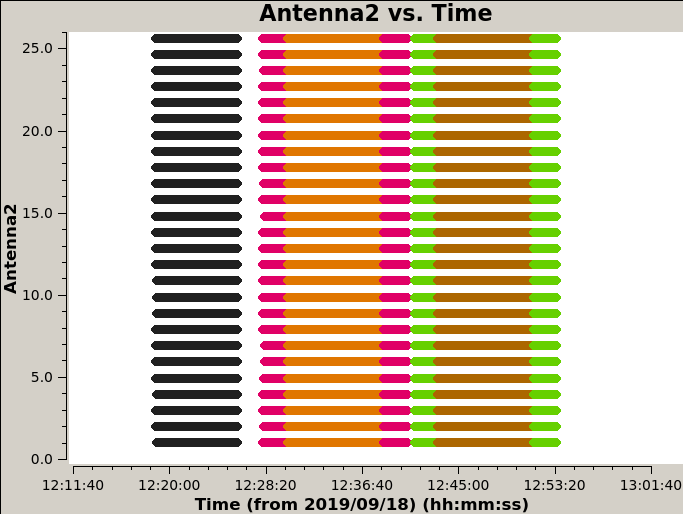

In [7]:
Image(filename=root + "/plots/obsplots/data_stream.png")

## Find Dead Antennas
Antennas that have low power should be flagged. This is also a good time to check for suitable reference antennas.

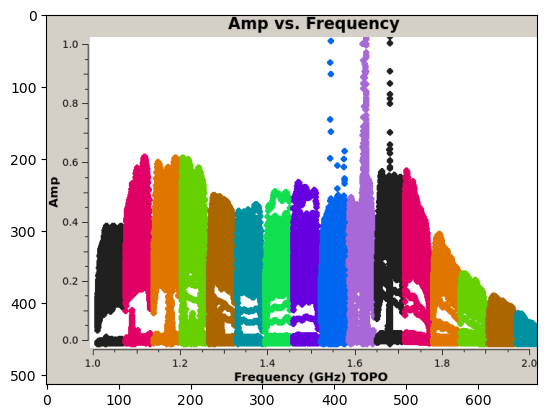

interactive(children=(IntSlider(value=13, description='ant', max=26, min=1), Output()), _dom_classes=('widget-…

<function __main__.plot_dead_ants(ant)>

In [8]:
def plot_dead_ants(ant):
    plotfile = root + f"/plots/dataplots/find_dead_ants_amp_vs_freq_ant_{ant}.png"
    img = mpimg.imread(plotfile)
    plt.imshow(img)
    
interact(plot_dead_ants, ant=(1, 26))
    

## RFI Inspection
The visibility amplitudes are first averaged across baselines and polarisation products. A modified Z-score is then computed across time as $Z_i = \frac{x_i - \mathrm{med}\{x_i\}_i}{\sigma_\mathrm{MAD}}$, 

where $\sigma_\mathrm{MAD} = \mathrm{med}\{\left|x_i - \mathrm{med}\{x_i\}_i\right|\}$ is the Median Absolute Deviation (MAD), and $x_i$ is the data (visibility amplitude) of the $i^\mathrm{th}$ integration.

The resulting Z-score is a spectrogram with dimensions of time and frequency. It can further be averaged across one of these dimensions to obtain a time series or a spectrum, which are useful for identifying broadband and persistent narrowband RFI respectively.

Use this to identify one clean channel per spectral window which will be used for the initial gain calibration.

#### Load Data

In [9]:

with h5py.File(root + f"/output/z_score_data.h5", "r") as f:
    z_score = f["z-score avg"][()]
    flags = f["flags avg"][()]
    freq_array = f["freq array"][()]
    time_array = f["time array"][()]
    ant_pairs = f["ant pairs"][()]
    dt = f["dt"][()]

# Load time integrations per scan
ntimes_file = os.path.join(root, f"output/ntimes.txt")
ntimes = np.loadtxt(ntimes_file).astype(int)

# time array
tisot = np.unique(Time(time_array, format="jd", scale="utc").isot)

z_score = np.ma.masked_array(z_score, mask=flags)

#### Plot

<IPython.core.display.Javascript object>


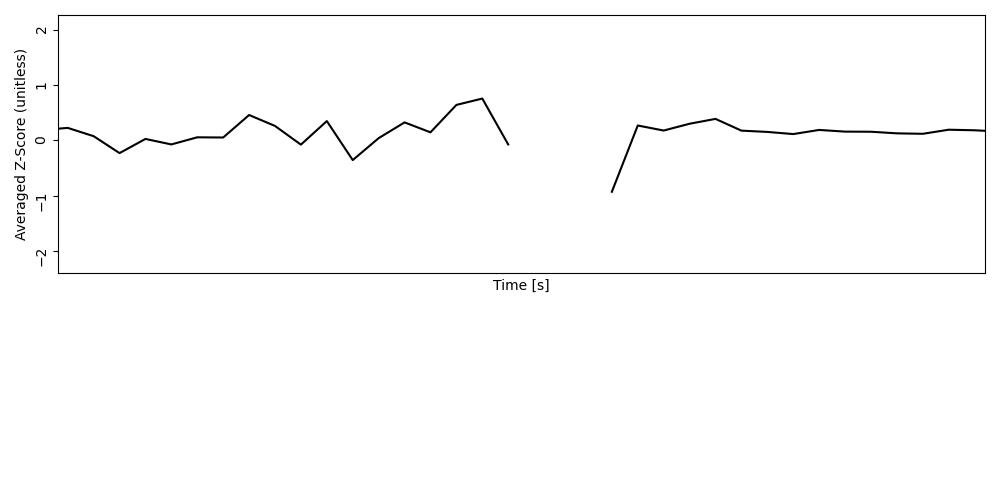

In [10]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=True)
ax = inspect.plot_time_series(tisot, np.ma.median(z_score, axis=1), ax, plot_masked=True)
ax.set_ylabel("Averaged Z-Score (unitless)")
ax.set_xticks(tisot[::100])
plt.tight_layout()

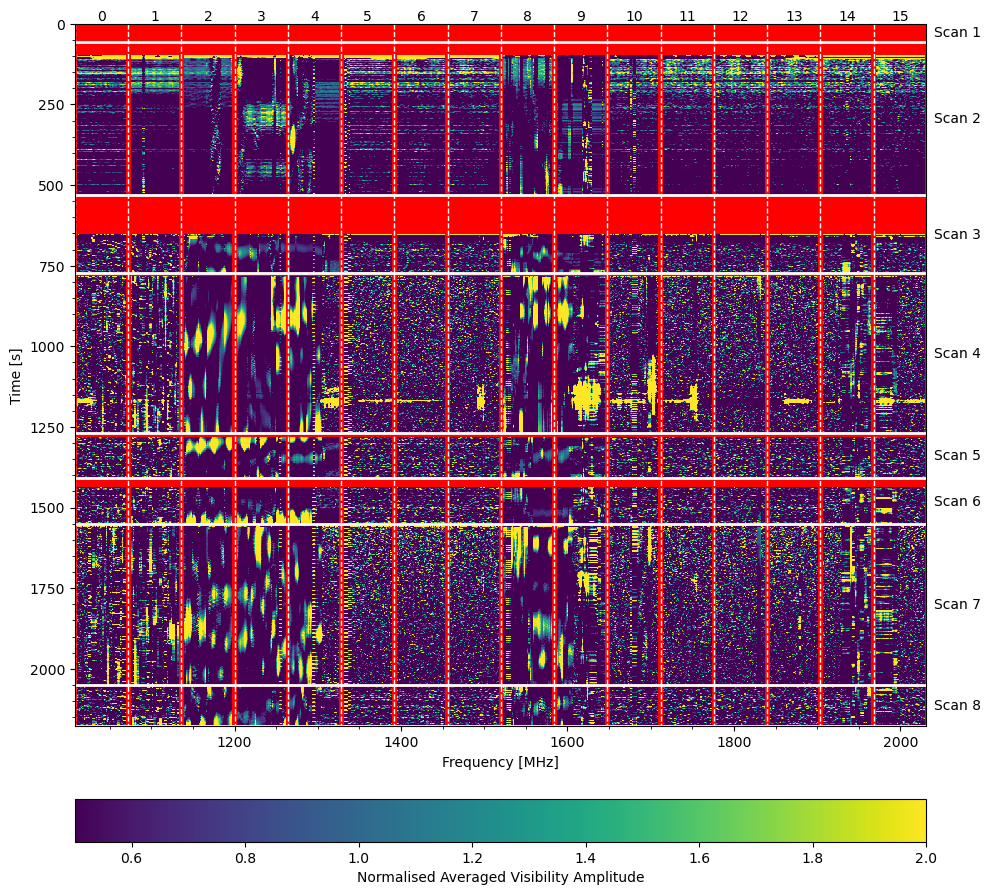

In [11]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))
ax, im = inspect.plot_wf(freq_array, z_score, 2, ntimes, vmin=0.5, vmax=2, cmap=cmap, ax=ax, plot_masked=True)
fig.colorbar(im, orientation="horizontal", pad=0.08, label="Normalised Averaged Visibility Amplitude")

In [12]:
def plot_wf_spw(i):
    inspect.plot_wf_spw(freq_array, z_score, i, 2, ntimes, plot_masked=True)
    
interact(plot_wf_spw, i=(0, 15))

interactive(children=(IntSlider(value=7, description='i', max=15), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_wf_spw(i)>

#### Manual Flagging
Applay manual time and frequency flags based on plots above.

In [13]:
"""
casatasks.flagdata(ms, timerange="2019/09/18/12:18:30~2019/09/18/12:18:55", reason="Manual Time Range Flagging", flagbackup=False)
casatasks.flagdata(ms, timerange="2019/09/18/12:27:59~2019/09/18/12:28:30", reason="Manual Time Range Flagging", flagbackup=False)
casatasks.flagdata(ms, timerange="2019/09/18/12:36:11~2019/09/18/12:36:15", reason="Manual Time Range Flagging", flagbackup=False)
casatasks.flagdata(ms, timerange="2019/09/18/12:36:31~2019/09/18/12:36:47", reason="Manual Time Range Flagging", flagbackup=False)
casatasks.flagdata(ms, timerange="2019/09/18/12:38:29~2019/09/18/12:38:35", reason="Manual Time Range Flagging", flagbackup=False)
casatasks.flagdata(ms, timerange="2019/09/18/12:41:09~2019/09/18/12:41:17", reason="Manual Time Range Flagging", flagbackup=False)
casatasks.flagdata(ms, timerange="2019/09/18/12:43:09~2019/09/18/12:43:13", reason="Manual Time Range Flagging", flagbackup=False)
casatasks.flagdata(ms, timerange="2019/09/18/12:51:29~2019/09/18/12:51:33", reason="Manual Time Range Flagging", flagbackup=False)
casatasks.flagdata(ms, timerange="2019/09/18/12:53:27~2019/09/18/12:53:29", reason="Manual Time Range Flagging", flagbackup=False)
"""

'\ncasatasks.flagdata(ms, timerange="2019/09/18/12:18:30~2019/09/18/12:18:55", reason="Manual Time Range Flagging", flagbackup=False)\ncasatasks.flagdata(ms, timerange="2019/09/18/12:27:59~2019/09/18/12:28:30", reason="Manual Time Range Flagging", flagbackup=False)\ncasatasks.flagdata(ms, timerange="2019/09/18/12:36:11~2019/09/18/12:36:15", reason="Manual Time Range Flagging", flagbackup=False)\ncasatasks.flagdata(ms, timerange="2019/09/18/12:36:31~2019/09/18/12:36:47", reason="Manual Time Range Flagging", flagbackup=False)\ncasatasks.flagdata(ms, timerange="2019/09/18/12:38:29~2019/09/18/12:38:35", reason="Manual Time Range Flagging", flagbackup=False)\ncasatasks.flagdata(ms, timerange="2019/09/18/12:41:09~2019/09/18/12:41:17", reason="Manual Time Range Flagging", flagbackup=False)\ncasatasks.flagdata(ms, timerange="2019/09/18/12:43:09~2019/09/18/12:43:13", reason="Manual Time Range Flagging", flagbackup=False)\ncasatasks.flagdata(ms, timerange="2019/09/18/12:51:29~2019/09/18/12:51:33

In [14]:
summary_before = np.load(root + "/output/manual_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + "/output/manual_flags_summary_after.npy", allow_pickle='TRUE').item()
        
print("Flag occupancy (percent) before and after manual flags:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after manual flags:

field J0542+4951
Before: 38, After: 41

field J1033+4116
Before: 52, After: 59

field J1130+3815
Before: 34, After: 40

field QSO J1048+4637
Before: 25, After: 30

field QSO J1137+3549
Before: 24, After: 27

scan 1
Before: 100, After: 100

scan 2
Before: 31, After: 34

scan 3
Before: 64, After: 73

scan 4
Before: 25, After: 30

scan 5
Before: 30, After: 34

scan 6
Before: 40, After: 46

scan 7
Before: 24, After: 27

scan 8
Before: 26, After: 34

antenna ea01
Before: 28, After: 33

antenna ea02
Before: 28, After: 33

antenna ea03
Before: 28, After: 33

antenna ea04
Before: 28, After: 33

antenna ea05
Before: 28, After: 33

antenna ea06
Before: 28, After: 33

antenna ea07
Before: 28, After: 33

antenna ea08
Before: 28, After: 33

antenna ea09
Before: 28, After: 33

antenna ea10
Before: 28, After: 33

antenna ea11
Before: 28, After: 33

antenna ea12
Before: 28, After: 33

antenna ea13
Before: 28, After: 33

antenna ea14
Before: 28, 

## Flux Calibrator Model
Print model flux densities and plot model amplitude vs. uv-distance. If the calibrator is not resolved, its amplitude should be constant across different uv-distances. If it is slightly resolved, the amplitude will decrease as a function of uv-distance.

In [15]:
setjy = np.load(root + "/output/setjy.npy", allow_pickle='TRUE').item()

print("model flux densities in Jy\n")

for spw in range(16):
    print("SPW {:2d}: I: {:.2f}, U: {:.2f}, V: {:.2f}, Q: {:.2f}".format(spw, *setjy["0"][str(spw)]["fluxd"]))

model flux densities in Jy

SPW  0: I: 28.13, U: 0.00, V: 0.00, Q: 0.00
SPW  1: I: 26.94, U: 0.00, V: 0.00, Q: 0.00
SPW  2: I: 25.85, U: 0.00, V: 0.00, Q: 0.00
SPW  3: I: 24.85, U: 0.00, V: 0.00, Q: 0.00
SPW  4: I: 23.92, U: 0.00, V: 0.00, Q: 0.00
SPW  5: I: 23.06, U: 0.00, V: 0.00, Q: 0.00
SPW  6: I: 22.27, U: 0.00, V: 0.00, Q: 0.00
SPW  7: I: 21.52, U: 0.00, V: 0.00, Q: 0.00
SPW  8: I: 20.83, U: 0.00, V: 0.00, Q: 0.00
SPW  9: I: 20.18, U: 0.00, V: 0.00, Q: 0.00
SPW 10: I: 19.57, U: 0.00, V: 0.00, Q: 0.00
SPW 11: I: 19.00, U: 0.00, V: 0.00, Q: 0.00
SPW 12: I: 18.46, U: 0.00, V: 0.00, Q: 0.00
SPW 13: I: 17.95, U: 0.00, V: 0.00, Q: 0.00
SPW 14: I: 17.47, U: 0.00, V: 0.00, Q: 0.00
SPW 15: I: 17.02, U: 0.00, V: 0.00, Q: 0.00


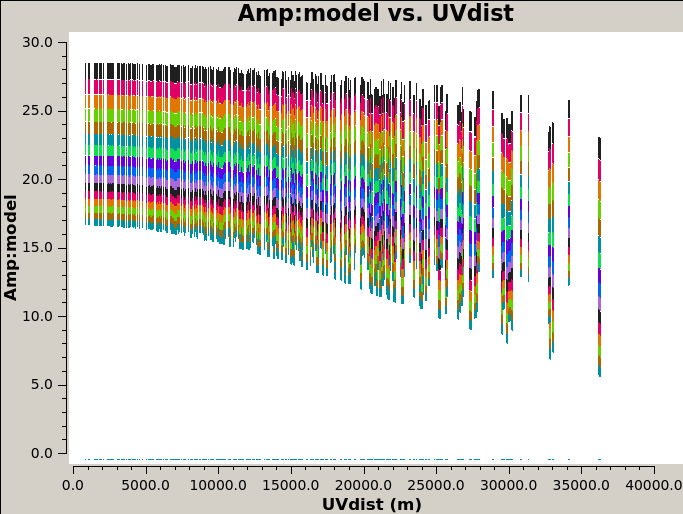

In [16]:
Image(filename=root + "/plots/calplots/setjy_model_amp_vs_uvdist.png")

## Prior Calibration

The prior calibration includes atmospheric opacity corrections, antenna offset corrections and requantizer (rq) gains. These are independent of calibrator observations and use external data instead.

### Weather
Plot weather data and print opacities. For frequencies below 10 GHz the opacity is negligibly small.  

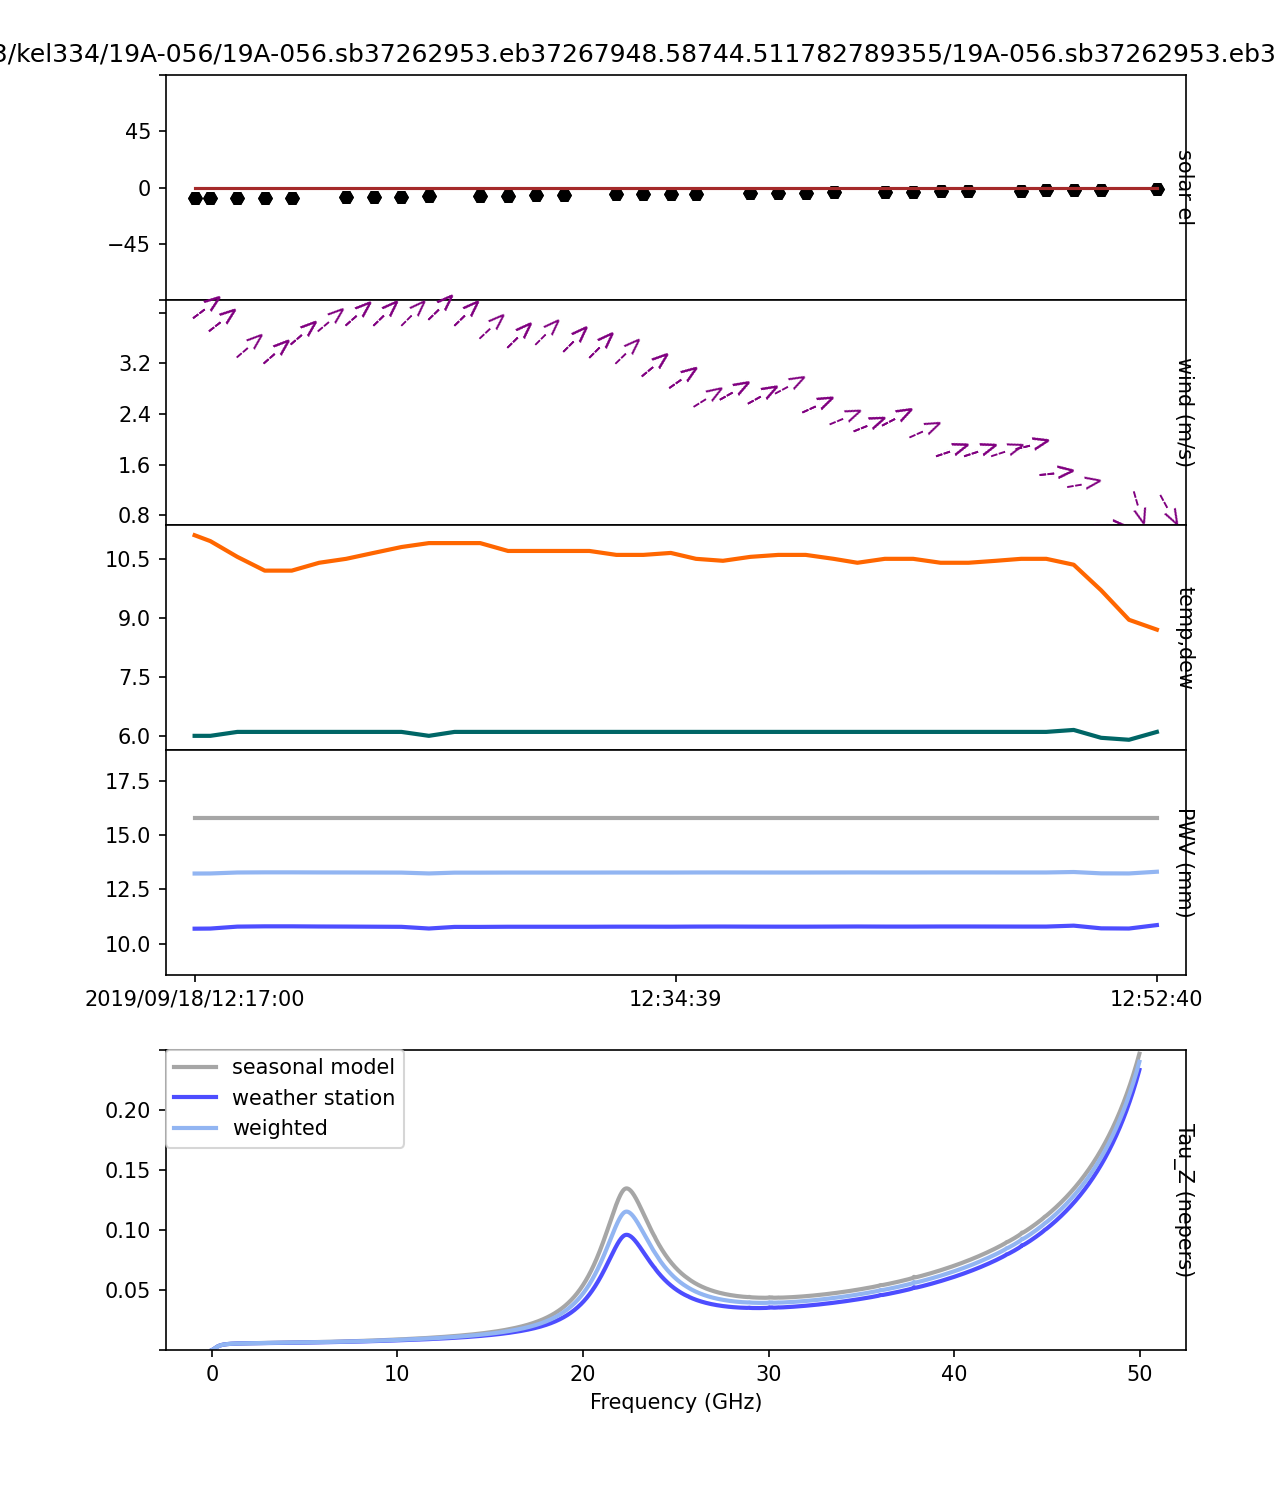

In [17]:
Image(filename=root + "/plots/calplots/weather.png")

In [18]:
opacities = np.load(root + "/output/weather.npy")

print("Opacities [Nepers]\n")

for spw, opacity in enumerate(opacities):
    print(f"SPW {spw}: {opacity}")

Opacities [Nepers]

SPW 0: 0.005156145504670995
SPW 1: 0.00521604230001692
SPW 2: 0.005268136303951705
SPW 3: 0.005313652182663858
SPW 4: 0.005354030156365918
SPW 5: 0.0053898666424734
SPW 6: 0.005422094745459627
SPW 7: 0.005451188753034495
SPW 8: 0.005477678822838807
SPW 9: 0.005501972286118477
SPW 10: 0.00552435923269206
SPW 11: 0.005545187791168971
SPW 12: 0.005564605491689138
SPW 13: 0.005582893355940872
SPW 14: 0.0056001610765702104
SPW 15: 0.0056165880715353745


## Plot Calibration Channels
These are the channels that have been selected for the gain calibration. They should be clean and should not exhibit any amplitude jumps.

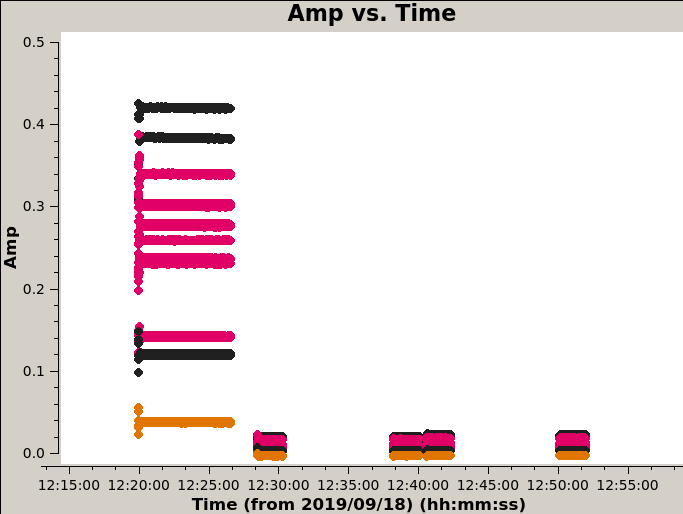

In [19]:
Image(filename=root + "/plots/dataplots/single_chans_amp_vs_time.png")

## Initial Calibration
The initial calibration is done to enable subsequent flagging with automated flagging routines such as CASA's RFlag. The calibration consists of an initial gain phase calibration, a delay calibration, an initial gain phase and amplitude calibration and a bandpass calibration. The two gain calibrations are used for the delay and bandpass calibrations, but are not applied to the data. The gain calibrations are done with a single channel per spectral window.

In [20]:
def plot_two_cols(im1, im2):
    """ 
    Plot two image side by side. E.g phase and amplitude.
    """
    fix, ax = plt.subplots(1, 2, figsize=(15, 5))

    if os.path.exists(im1):
        img_1 = mpimg.imread(im1)
        ax[0].imshow(img_1)

    if os.path.exists(im2):
        img_2 = mpimg.imread(im2)
        ax[1].imshow(img_2)

### Specify Gain Tables

In [21]:
# specify calibration table names
rnd = 0
delay_init_table = f"{name}.p.G{rnd}"
delay_table = f"{name}.K{rnd}"
bandpass_init_table = f"{name}.ap.G{rnd}"
bandpass_table = f"{name}.B{rnd}"

### Delay Initial Gain Calibration
This is an initial per-integration phase calibration and is done to avoid decorrelation under temporal averaging in the subsequent delay calibration. The gain phase should be stable in time. Antennas or spectral windows that have gain phase discontinuities should be flagged. If all but the reference antenna exhibit phase jumps, a difference reference antenna should be chosen.

In [22]:
def plot_delay_init_cal(ant):
    img = mpimg.imread(root + f"/plots/calplots/{delay_init_table}_ant_{ant}_Poln0,1.png")
    imgplot = plt.imshow(img)

interact(plot_delay_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_delay_init_cal(ant)>

### Delay Calibration
The delay calibration is done by fitting for the phase slopes across frequency with respect to the reference antenna. The first and last 15 channels of the spectral windows are not used in this step, since they have lower gains. The delays should lie between -5 and 5 ns, and anything outside that range should be treated with suspicion.

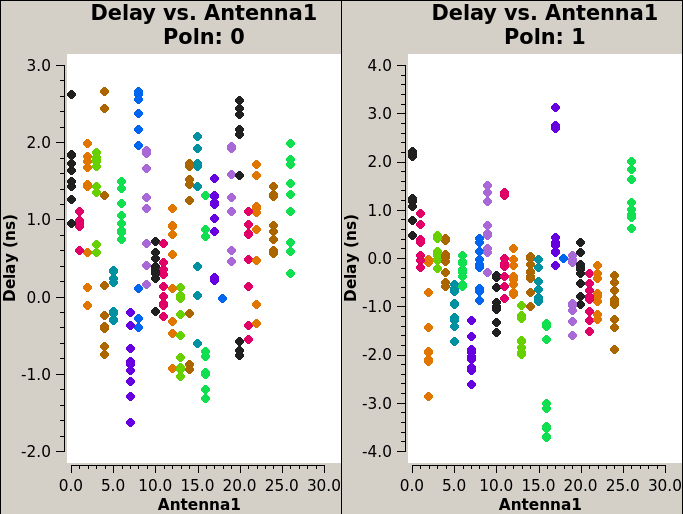

In [23]:
Image(filename=root + f"/plots/calplots/{delay_table}_Poln0,1.png")

### Bandpass Initial Gain Calibration
Similarly to above, we perform an initial gain calibration for the bandpass calibration, but this time we also solve for the amplitudes. The phases and amplitudes should be constant with time and discontinuous solutions should be flagged.

In [24]:
def plot_bandpass_init_cal(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_init_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_init_table}_phase_ant_{ant}_Poln0,1.png"
    )

interact(plot_bandpass_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_init_cal(ant)>

### Bandpass Calibration
The amplitudes and phases of the bandpass calibration should be close to 1 and zero respectively after the initial gain calibration. Discontinuities should be flagged.

In [25]:
def plot_bandpass_ant(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_ant_{ant}_Poln0,1.png"
    )
    
interact(plot_bandpass_ant, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_ant(ant)>

Iterate through spectral windows and colorise by antenna. 

In [26]:
def plot_bandpass_spw(spw):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_spw_{spw}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_spw_{spw}_Poln0,1.png"
    )

interact(plot_bandpass_spw, spw=(0, conf["spw"]-1))

interactive(children=(IntSlider(value=7, description='spw', max=15), Output()), _dom_classes=('widget-interact…

<function __main__.plot_bandpass_spw(spw)>

### Plot Corrected Data
This data is averaged in time and colorised by antenna.

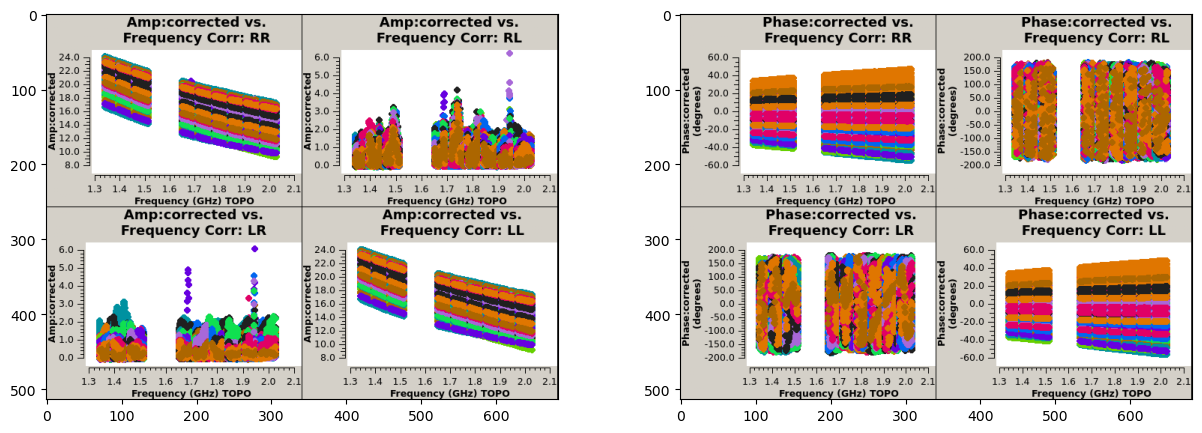

In [27]:
plot_two_cols(
    root + f"/plots/dataplots/fluxcal_initcal_round_0_amp_vs_freq_CorrRR,RL,LR,LL.png",
    root + f"/plots/dataplots/fluxcal_initcal_round_0_phase_vs_freq_CorrRR,RL,LR,LL.png"
)

#### Plot Averaged Corrected Data
Iterate through spectral windows to identify RFI and flag bad channels manually below.

In [28]:
def plot_corrected_spw(spw):
    img = mpimg.imread(root + f"/plots/dataplots/fluxcal_initcal_round_0_amp_vs_freq_avg_spw_{spw}_CorrRR,RL,LR,LL.png")
    plt.imshow(img)

interact(plot_corrected_spw, spw=(0, conf["spw"]-1))

interactive(children=(IntSlider(value=7, description='spw', max=15), Output()), _dom_classes=('widget-interact…

<function __main__.plot_corrected_spw(spw)>

### Flagging Summary
If no calibration solutions are available, data may be flagged (e.g. bad spectral windows).

In [29]:
rnd=0
summary_before = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_after.npy", allow_pickle='TRUE').item()

print(f"Flag occupancy (percent) before and after initial calibration round {rnd}:\n")

print_summary("field")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after initial calibration round 0:

field J0542+4951
Before: 41, After: 68

antenna ea01
Before: 36, After: 65

antenna ea02
Before: 36, After: 65

antenna ea03
Before: 36, After: 65

antenna ea04
Before: 36, After: 65

antenna ea05
Before: 36, After: 65

antenna ea06
Before: 36, After: 65

antenna ea07
Before: 36, After: 65

antenna ea08
Before: 36, After: 65

antenna ea09
Before: 36, After: 65

antenna ea10
Before: 36, After: 65

antenna ea11
Before: 36, After: 65

antenna ea12
Before: 36, After: 65

antenna ea13
Before: 36, After: 65

antenna ea14
Before: 36, After: 65

antenna ea15
Before: 36, After: 65

antenna ea16
Before: 36, After: 65

antenna ea17
Before: 36, After: 65

antenna ea18
Before: 36, After: 65

antenna ea19
Before: 36, After: 65

antenna ea20
Before: 36, After: 65

antenna ea22
Before: 36, After: 65

antenna ea23
Before: 37, After: 65

antenna ea24
Before: 36, After: 65

antenna ea25
Before: 100, After: 100

antenna ea26
Before: 3

## First Round of Flagging on Primary Calibrator
The first round of flagging is performed on the primary calibrator only. The flagging routine runs RFlag with timedevscale=5.0, freqdevscale=5.0 and freqfit=line on a ABS_RL, ABS_LR, ABS_LL, ABS_RR, REAL_LL, REAL_RR, IMAG_LL and IMAG_RR, where for the real and imaginary parts RFLag is performed on the residual (corrected-model) data. TFCrop is run with timecutoff=4.0 and freqcutoff=4.0 on ABS_RL, ABS_LR, ABS_LL and ABS_RR. Flags are extended across polarisations. The plots below show the amplitudes and phases of the calibrators before and after flagging respectively.

### Before Flagging

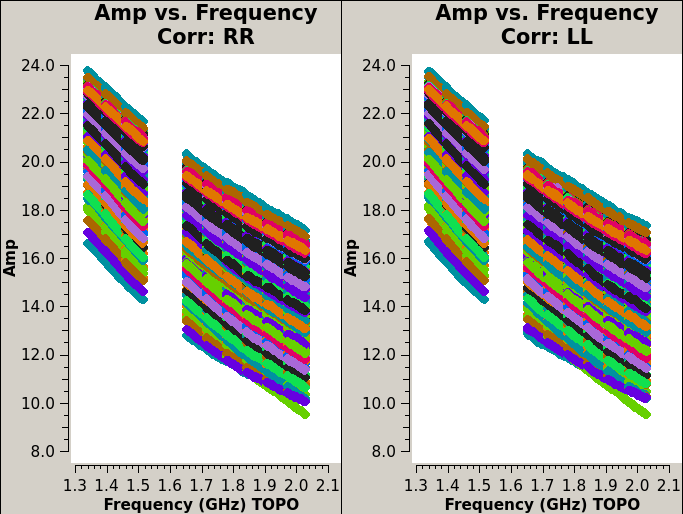

In [47]:
Image(filename=root + "/plots/dataplots/before_fluxcal_round_0_flagging_amp_vs_freq_CorrRR,LL.png")

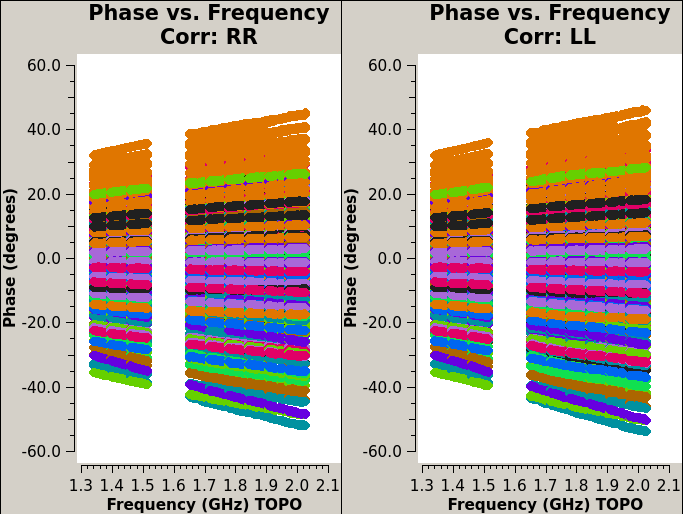

In [48]:
Image(filename=root + "/plots/dataplots/before_fluxcal_round_0_flagging_phase_vs_freq_CorrRR,LL.png")

### After Flagging

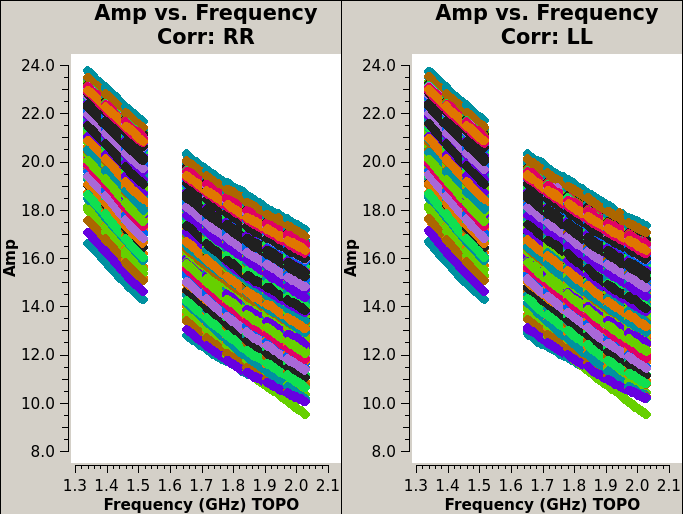

In [49]:
Image(filename=root + "/plots/dataplots/after_fluxcal_round_0_flagging_amp_vs_freq_CorrRR,LL.png")

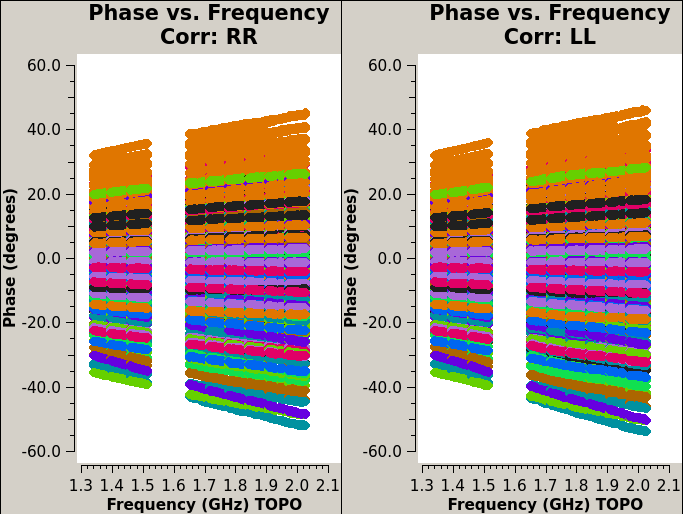

In [50]:
Image(filename=root + "/plots/dataplots/after_fluxcal_round_0_flagging_phase_vs_freq_CorrRR,LL.png")

### Summary

In [77]:
summary_before = np.load(root + f"/output/fluxcal_round_{rnd}_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/fluxcal_round_{rnd}_flags_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) before and after flagging the flux calibrator:\n")

print_summary("field")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after flagging the flux calibrator:

field J0542+4951
Before: 67.6941, After: 67.7272

antenna ea01
Before: 65.0081, After: 65.0304

antenna ea02
Before: 65.0033, After: 65.0199

antenna ea03
Before: 65.0156, After: 65.0478

antenna ea04
Before: 65.0518, After: 65.0905

antenna ea05
Before: 65.0207, After: 65.0403

antenna ea06
Before: 65.0977, After: 65.1591

antenna ea07
Before: 65.0991, After: 65.1426

antenna ea08
Before: 65.0940, After: 65.1226

antenna ea09
Before: 65.1013, After: 65.1203

antenna ea10
Before: 65.1304, After: 65.1888

antenna ea11
Before: 65.0386, After: 65.0608

antenna ea12
Before: 65.1691, After: 65.2481

antenna ea13
Before: 65.0438, After: 65.0918

antenna ea14
Before: 64.9751, After: 64.9816

antenna ea15
Before: 65.0752, After: 65.1048

antenna ea16
Before: 65.0165, After: 65.0333

antenna ea17
Before: 65.1522, After: 65.2136

antenna ea18
Before: 65.5401, After: 65.5642

antenna ea19
Before: 65.1561, After: 65.2267

ant

## Semi-Final Calibration
The steps from the intitial calibration are repeated. 

### Specify Gain Tables

In [52]:
# specify calibration table names
rnd = 1
delay_init_table = f"{name}.p.G{rnd}"
delay_table = f"{name}.K{rnd}"
bandpass_init_table = f"{name}.ap.G{rnd}"
bandpass_table = f"{name}.B{rnd}"

### Delay Initial Gain Calibration

In [53]:
def plot_delay_init_cal(ant):
    img = mpimg.imread(root + f"/plots/calplots/{delay_init_table}_ant_{ant}_Poln0,1.png")
    imgplot = plt.imshow(img)

interact(plot_delay_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_delay_init_cal(ant)>

### Delay Calibration

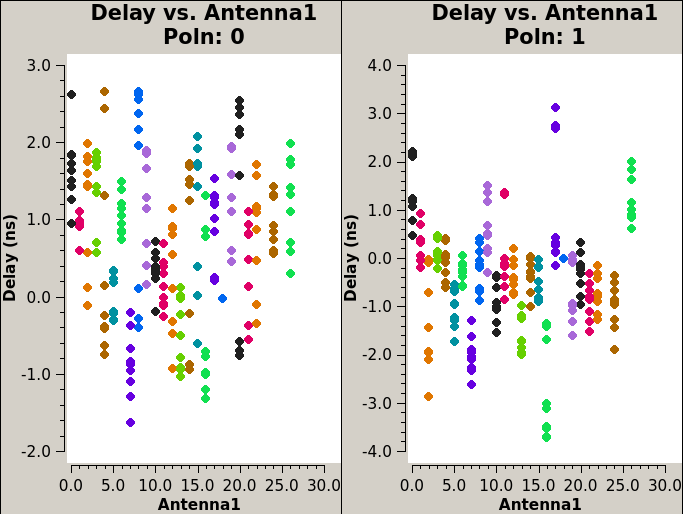

In [54]:
Image(filename=root + f"/plots/calplots/{delay_table}_Poln0,1.png")

### Bandpass Initial Gain Calibration

In [55]:
def plot_bandpass_init_cal(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_init_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_init_table}_phase_ant_{ant}_Poln0,1.png"
    )

interact(plot_bandpass_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_init_cal(ant)>

### Bandpass Calibration

In [56]:
def plot_bandpass_ant(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_ant_{ant}_Poln0,1.png"
    )
    
interact(plot_bandpass_ant, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_ant(ant)>

Iterate through spectral windows and colorise by antenna. 

In [57]:
def plot_bandpass_spw(spw):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_spw_{spw}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_spw_{spw}_Poln0,1.png"
    )

interact(plot_bandpass_spw, spw=(0, conf["spw"]-1))

interactive(children=(IntSlider(value=7, description='spw', max=15), Output()), _dom_classes=('widget-interact…

<function __main__.plot_bandpass_spw(spw)>

### Plot Corrected Data
This data is averaged in time and colorised by antenna.

False

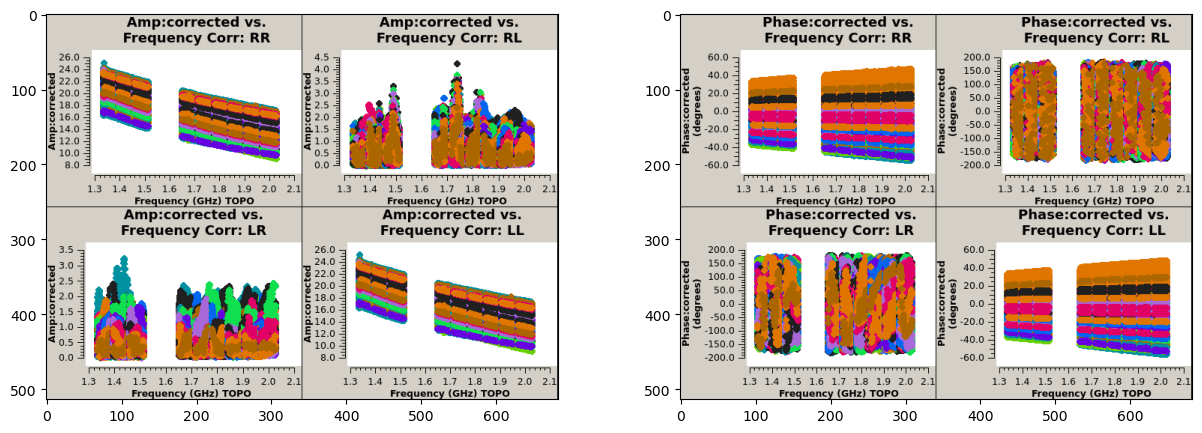

In [58]:
plot_two_cols(
    root + f"/plots/dataplots/fluxcal_init_cal_amp_vs_freq_CorrRR,RL,LR,LL.png",
    root + f"/plots/dataplots/fluxcal_init_cal_phase_vs_freq_CorrRR,RL,LR,LL.png"
)

"fluxcal_init_cal_amp_vs_freq.png" in os.listdir(root + f"/plots/dataplots/")

#### Plot Averaged Corrected Data
Iterate through spectral windows to identify RFI and flag bad channels manually below.

In [59]:
def plot_corrected_spw(spw):
    img = mpimg.imread(root + f"/plots/dataplots/fluxcal_init_cal_amp_vs_freq_avg_spw_{spw}_CorrRR,RL,LR,LL.png")
    plt.imshow(img)

interact(plot_corrected_spw, spw=(0, conf["spw"]-1))

interactive(children=(IntSlider(value=7, description='spw', max=15), Output()), _dom_classes=('widget-interact…

<function __main__.plot_corrected_spw(spw)>

### Flag Bandpass Outliers (RFI)

In [60]:
"""
casatasks.flagdata(ms, spw="5:0~12", reason="Manual Frequency Flagging", flagbackup=False)
casatasks.flagdata(ms, spw="10:26~34", reason="Manual Frequency Flagging", flagbackup=False)
casatasks.flagdata(ms, spw="14:28~37", reason="Manual Frequency Flagging", flagbackup=False)
"""

'\ncasatasks.flagdata(ms, spw="5:0~12", reason="Manual Frequency Flagging", flagbackup=False)\ncasatasks.flagdata(ms, spw="10:26~34", reason="Manual Frequency Flagging", flagbackup=False)\ncasatasks.flagdata(ms, spw="14:28~37", reason="Manual Frequency Flagging", flagbackup=False)\n'

### Flagging Summary
If no calibration solutions are available, data may be flagged (e.g. bad spectral windows).

In [61]:
rnd=1
summary_before = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_after.npy", allow_pickle='TRUE').item()

print(f"Flag occupancy (percent) before and after initial calibration round {rnd}:\n")

print_summary("field")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after initial calibration round 1:

field J0542+4951
Before: 68, After: 68

antenna ea01
Before: 65, After: 65

antenna ea02
Before: 65, After: 65

antenna ea03
Before: 65, After: 65

antenna ea04
Before: 65, After: 65

antenna ea05
Before: 65, After: 65

antenna ea06
Before: 65, After: 65

antenna ea07
Before: 65, After: 65

antenna ea08
Before: 65, After: 65

antenna ea09
Before: 65, After: 65

antenna ea10
Before: 65, After: 65

antenna ea11
Before: 65, After: 65

antenna ea12
Before: 65, After: 65

antenna ea13
Before: 65, After: 65

antenna ea14
Before: 65, After: 65

antenna ea15
Before: 65, After: 65

antenna ea16
Before: 65, After: 65

antenna ea17
Before: 65, After: 65

antenna ea18
Before: 66, After: 66

antenna ea19
Before: 65, After: 65

antenna ea20
Before: 65, After: 65

antenna ea22
Before: 65, After: 65

antenna ea23
Before: 65, After: 65

antenna ea24
Before: 65, After: 65

antenna ea25
Before: 100, After: 100

antenna ea26
Before: 6

## Second Round of Flagging
The flagging is repeated, but this time on all calibrators.

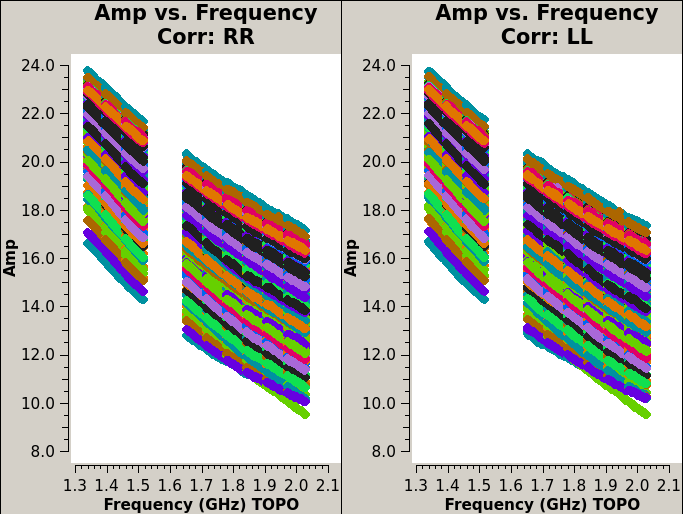

In [62]:
# primary calibrator
Image(filename=root + "/plots/dataplots/before_fluxcal_round_1_flagging_amp_vs_freq_CorrRR,LL.png")

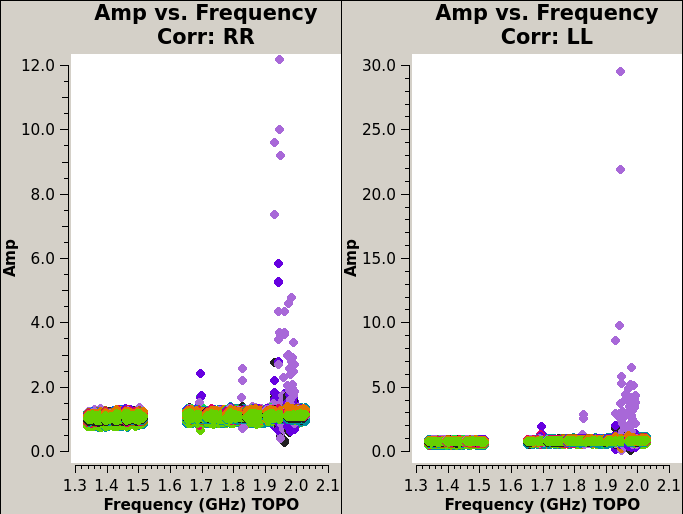

In [63]:
# phase calibrators
Image(filename=root + "/plots/dataplots/before_phasecal_round_0_flagging_amp_vs_freq_CorrRR,LL.png")

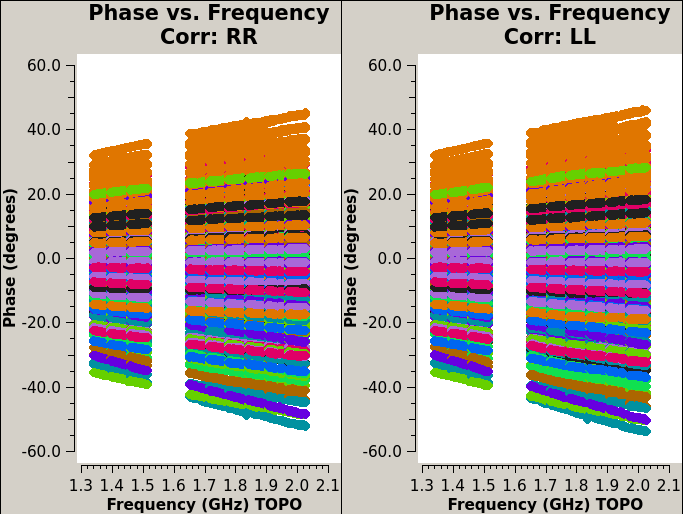

In [64]:
# primary calibrator
Image(filename=root + "/plots/dataplots/before_fluxcal_round_1_flagging_phase_vs_freq_CorrRR,LL.png")

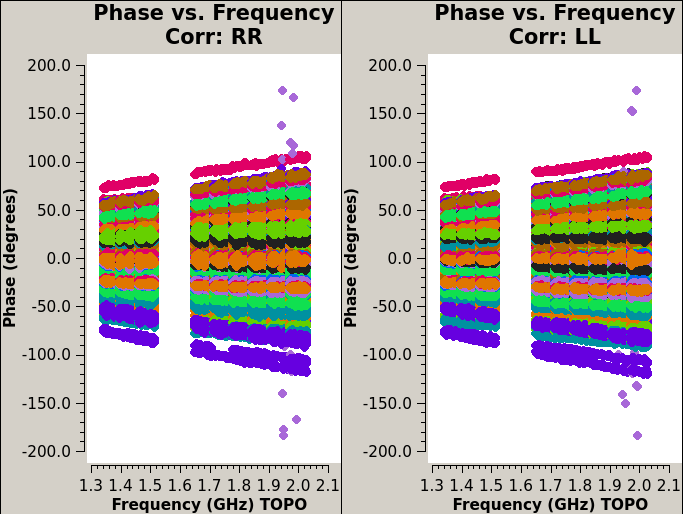

In [65]:
# phase calibrators
Image(filename=root + "/plots/dataplots/before_phasecal_round_0_flagging_phase_vs_freq_CorrRR,LL.png")

### After Flagging

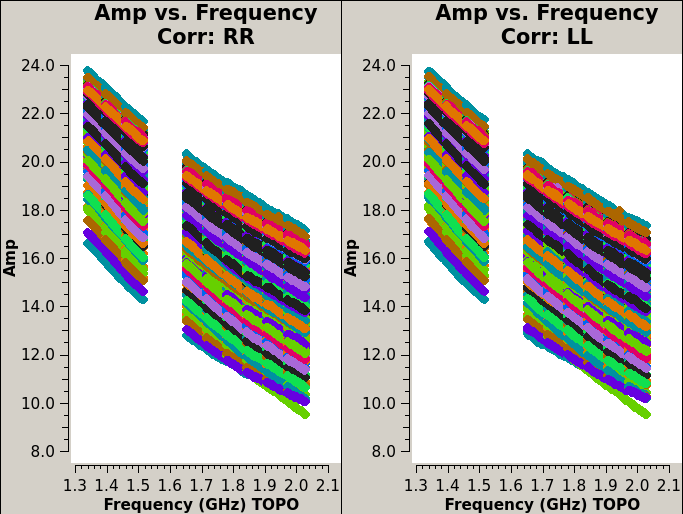

In [66]:
# primary calibrator
Image(filename=root + "/plots/dataplots/after_fluxcal_round_1_flagging_amp_vs_freq_CorrRR,LL.png")

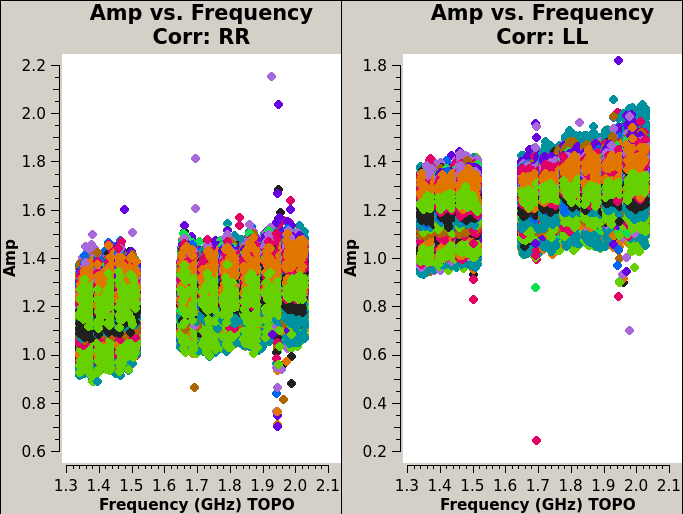

In [86]:
# phase calibrators
Image(filename=root + "/plots/dataplots/after_phasecal_round_0_flagging_amp_vs_freq_CorrRR,LL.png")

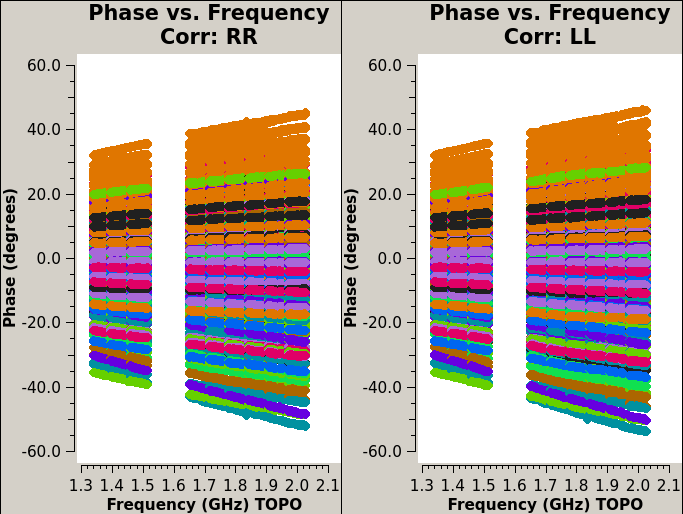

In [68]:
# primary calibrator
Image(filename=root + "/plots/dataplots/after_fluxcal_round_1_flagging_phase_vs_freq_CorrRR,LL.png")

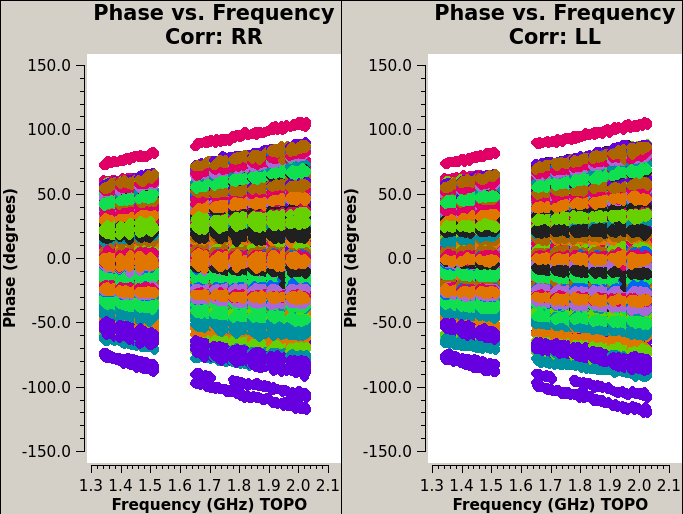

In [69]:
# phase calibrators
Image(filename=root + "/plots/dataplots/after_phasecal_round_0_flagging_phase_vs_freq_CorrRR,LL.png")

### Flagging Summary

In [78]:
summary_before = np.load(root + f"/output/fluxcal_round_{rnd}_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/fluxcal_round_{rnd}_flags_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) before and after flagging the flux calibrator:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after flagging the flux calibrator:

field J0542+4951
Before: 67.6941, After: 67.7272

scan 1
Before: 100.0000, After: 100.0000

scan 2
Before: 63.8935, After: 63.9304

antenna ea01
Before: 65.0081, After: 65.0304

antenna ea02
Before: 65.0033, After: 65.0199

antenna ea03
Before: 65.0156, After: 65.0478

antenna ea04
Before: 65.0518, After: 65.0905

antenna ea05
Before: 65.0207, After: 65.0403

antenna ea06
Before: 65.0977, After: 65.1591

antenna ea07
Before: 65.0991, After: 65.1426

antenna ea08
Before: 65.0940, After: 65.1226

antenna ea09
Before: 65.1013, After: 65.1203

antenna ea10
Before: 65.1304, After: 65.1888

antenna ea11
Before: 65.0386, After: 65.0608

antenna ea12
Before: 65.1691, After: 65.2481

antenna ea13
Before: 65.0438, After: 65.0918

antenna ea14
Before: 64.9751, After: 64.9816

antenna ea15
Before: 65.0752, After: 65.1048

antenna ea16
Before: 65.0165, After: 65.0333

antenna ea17
Before: 65.1522, After: 65.2136

antenna ea18


In [80]:
summary_before = np.load(root + f"/output/phasecal_round_0_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/phasecal_round_0_flags_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) before and after flagging the phase calibrators:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after flagging the phase calibrators:

field J1033+4116
Before: 77.2730, After: 77.3918

field J1130+3815
Before: 67.3409, After: 67.5700

scan 3
Before: 85.0455, After: 85.1291

scan 5
Before: 63.6431, After: 63.8236

scan 6
Before: 70.2967, After: 70.5312

scan 8
Before: 64.0157, After: 64.2386

antenna ea01
Before: 70.9633, After: 71.4078

antenna ea02
Before: 70.9633, After: 71.1135

antenna ea03
Before: 70.9633, After: 71.0703

antenna ea04
Before: 70.9633, After: 70.9807

antenna ea05
Before: 70.9633, After: 71.0680

antenna ea06
Before: 70.9633, After: 70.9840

antenna ea07
Before: 70.9633, After: 71.1019

antenna ea08
Before: 70.9633, After: 71.5550

antenna ea09
Before: 70.9633, After: 71.0531

antenna ea10
Before: 70.9633, After: 71.4318

antenna ea11
Before: 70.9633, After: 70.9837

antenna ea12
Before: 70.9633, After: 71.2265

antenna ea13
Before: 70.9633, After: 71.0627

antenna ea14
Before: 70.9633, After: 71.0455

antenna ea15
Before: 

In [81]:
summary_before = np.load(root + f"/output/phasecal_MAD_clipping_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/phasecal_MAD_clipping_flags_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) before and after flagging MAD clippting the phase calibrators:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after flagging MAD clippting the phase calibrators:

field J1033+4116
Before: 77.3918, After: 77.4007

field J1130+3815
Before: 67.5700, After: 67.5833

scan 3
Before: 85.1291, After: 85.1353

scan 5
Before: 63.8236, After: 63.8372

scan 6
Before: 70.5312, After: 70.5447

scan 8
Before: 64.2386, After: 64.2517

antenna ea01
Before: 71.4078, After: 71.4201

antenna ea02
Before: 71.1135, After: 71.1254

antenna ea03
Before: 71.0703, After: 71.0762

antenna ea04
Before: 70.9807, After: 70.9896

antenna ea05
Before: 71.0680, After: 71.0761

antenna ea06
Before: 70.9840, After: 70.9958

antenna ea07
Before: 71.1019, After: 71.1084

antenna ea08
Before: 71.5550, After: 71.5724

antenna ea09
Before: 71.0531, After: 71.0629

antenna ea10
Before: 71.4318, After: 71.4479

antenna ea11
Before: 70.9837, After: 70.9950

antenna ea12
Before: 71.2265, After: 71.2384

antenna ea13
Before: 71.0627, After: 71.0757

antenna ea14
Before: 71.0455, After: 71.0731

antenna

## Flux Bootstraping
The flux scale of the primary calibrator is transfered to the secondary calibrators. An initial phase and amplitude gain calibration is performed on the secondary phase calibrators. First, a per integration phase calibration is performed, and then a phase and amplitude gain calibration on a long interval (scan). The latter is done twice, once by keeping the amplitudes normalised and once unrestrained. The formed is used to flag bad solutions.
After the initial calibration, a spectral index model is fitted to the secondary calibrators. 

### Plot Gain Calibrations

In [54]:
# specify calibration tables
short_gain_table = f"{name}_short.G"
long_gain_table = f"{name}_long.G"
flux_gain_table = f"{name}_fluxgain.G"

In [55]:
def plot_short_gain(ant):
    img = mpimg.imread(root + f"/plots/calplots/{short_gain_table}_phase_ant_{ant}_Poln0,1.png")
    imgplot = plt.imshow(img)

interact(plot_short_gain, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_short_gain(ant)>

In [56]:
def plot_long_gain(ant):
    plot_two_cols(
        root + f"/plots/calplots/{long_gain_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{long_gain_table}_phase_ant_{ant}_Poln0,1.png"
    )

interact(plot_long_gain, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_long_gain(ant)>

In [57]:
def plot_flux_gain(ant):
    plot_two_cols(
        root + f"/plots/calplots/{flux_gain_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{flux_gain_table}_phase_ant_{ant}_Poln0,1.png"
    )

interact(plot_flux_gain, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_flux_gain(ant)>

### Plot Model
Check that the models have reasonable flux densities and spectral indices.

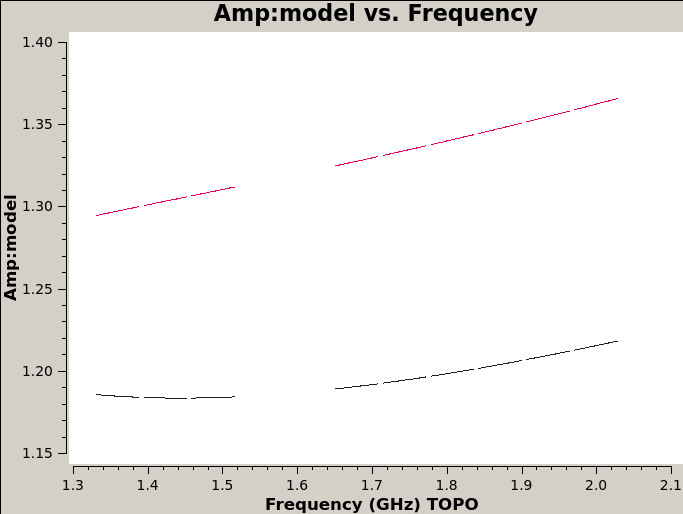

In [58]:
Image(filename=root + "/plots/dataplots/model_amp_vs_freq.png")

### Plot Residuals
Check that the residuals are small.

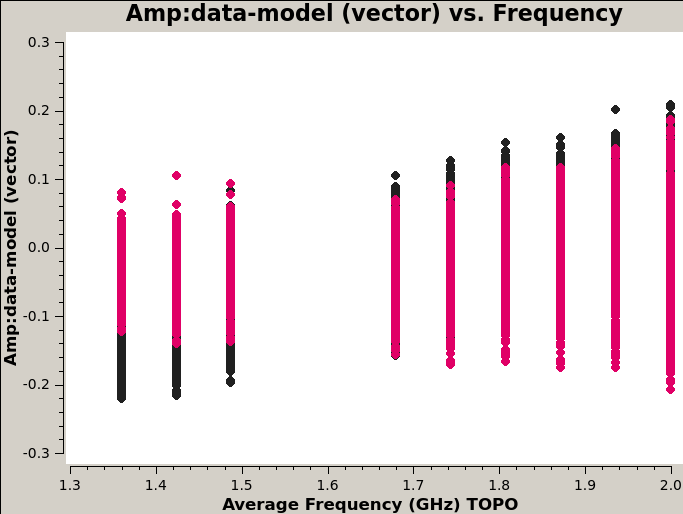

In [59]:
Image(filename=root + "/plots/dataplots/model_amp_vs_freq_residual.png")

### Summary

In [60]:
summary_before = np.load(root + f"/output/fluxboot_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/fluxboot_flags_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) before and after flux bootstrapping:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

FileNotFoundError: [Errno 2] No such file or directory: '/DATA/CARINA_3/kel334/19A-056/19A-056.sb37262953.eb37267948.58744.511782789355/output/fluxboot_flags_summary_after.npy'

## Final Calibration
First, the initial calibration (delay and bandpass) are repeated on the primary calibrator. Then, the final gains of the calibrators are derived.

### Specify Gain Tables

In [60]:
# specify calibration table names
rnd = 2
delay_init_table = f"{name}.p.G{rnd}"
delay_table = f"{name}.K{rnd}"
bandpass_init_table = f"{name}.ap.G{rnd}"
bandpass_table = f"{name}.B{rnd}"

fluxcal_phase_table = f"{name}_fluxcal_phase.Gfinal"
short_gain_table = f"{name}_short.Gfinal"
amp_gain_table = f"{name}_amp.Gfinal"
phase_gain_table = f"{name}_phase.Gfinal"

### Delay Initial Gain Calibration

In [61]:
def plot_delay_init_cal(ant):
    img = mpimg.imread(root + f"/plots/calplots/{delay_init_table}_ant_{ant}_Poln0,1.png")
    imgplot = plt.imshow(img)

interact(plot_delay_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_delay_init_cal(ant)>

### Delay Calibration

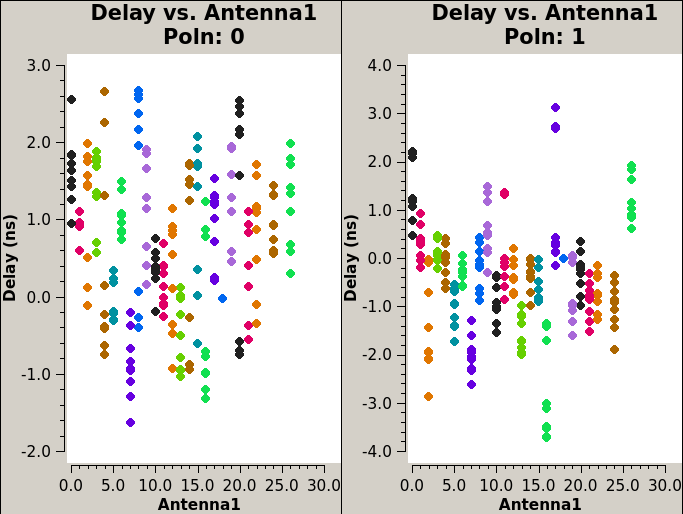

In [62]:
Image(filename=root + f"/plots/calplots/{delay_table}_Poln0,1.png")

### Bandpass Initial Gain Calibration

In [63]:
def plot_bandpass_init_cal(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_init_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_init_table}_phase_ant_{ant}_Poln0,1.png"
    )

interact(plot_bandpass_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_init_cal(ant)>

### Bandpass Calibration

In [64]:
def plot_bandpass_ant(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_ant_{ant}_Poln0,1.png"
    )
    
interact(plot_bandpass_ant, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_ant(ant)>

Iterate through spectral windows and colorise by antenna. 

In [65]:
def plot_bandpass_spw(spw):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_spw_{spw}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_spw_{spw}_Poln0,1.png"
    )

interact(plot_bandpass_spw, spw=(0, conf["spw"]-1))

interactive(children=(IntSlider(value=7, description='spw', max=15), Output()), _dom_classes=('widget-interact…

<function __main__.plot_bandpass_spw(spw)>

### Flux Calibrator Final Gain Phase

In [66]:
def plot_final_fluxcal_phase(ant):
    img = mpimg.imread(root + f'/plots/calplots/{fluxcal_phase_table}_ant_{ant}_Poln0,1.png')
    plt.imshow(img)

interact(plot_final_fluxcal_phase, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_final_fluxcal_phase(ant)>

### Short Interval Gain Calibration
This is an initial calibration done on a per-integration basis on the calibrators.

In [67]:
def plot_final_short_gain_phase(ant):
    img = mpimg.imread(root + f'/plots/calplots/{short_gain_table}_phase_ant_{ant}_Poln0,1.png')
    plt.imshow(img)

interact(plot_final_short_gain_phase, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_final_short_gain_phase(ant)>

### Long Interval Gain Calibration
The gain amplitudes of the calibrators of solved for using the initial gain phase calibration above.

In [68]:
def plot_final_long_gain(ant):
    plot_two_cols(
        root + f'/plots/calplots/{amp_gain_table}_amp_ant_{ant}_Poln0,1.png',
        root + f'/plots/calplots/{amp_gain_table}_phase_ant_{ant}_Poln0,1.png'
    )

interact(plot_final_long_gain, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_final_long_gain(ant)>

### Phase Calibration
Derive the final gain phases of the calibrators. That of the primary calibrator should be close to zero, since it was already derived and applied earlier on.

In [69]:
def plot_final_phase(ant):
    img = mpimg.imread(root + f'/plots/calplots/{phase_gain_table}_phase_ant_{ant}_Poln0,1.png')
    plt.imshow(img)

interact(plot_final_phase, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_final_phase(ant)>

### Flagging Summary

In [70]:
rnd=1
summary_before = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_after.npy", allow_pickle='TRUE').item()

print(f"Flag occupancy (percent) before and after final delay and bandpass calibration:\n")

print_summary("field")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after final delay and bandpass calibration:

field J0542+4951
Before: 66, After: 66

antenna ea01
Before: 63, After: 63

antenna ea02
Before: 63, After: 63

antenna ea03
Before: 63, After: 63

antenna ea04
Before: 63, After: 63

antenna ea05
Before: 63, After: 63

antenna ea06
Before: 63, After: 63

antenna ea07
Before: 63, After: 63

antenna ea08
Before: 63, After: 63

antenna ea09
Before: 63, After: 63

antenna ea10
Before: 63, After: 64

antenna ea11
Before: 63, After: 63

antenna ea12
Before: 64, After: 64

antenna ea13
Before: 63, After: 63

antenna ea14
Before: 63, After: 63

antenna ea15
Before: 63, After: 63

antenna ea16
Before: 63, After: 63

antenna ea17
Before: 63, After: 63

antenna ea18
Before: 63, After: 63

antenna ea19
Before: 63, After: 63

antenna ea20
Before: 63, After: 63

antenna ea22
Before: 63, After: 63

antenna ea23
Before: 63, After: 63

antenna ea24
Before: 63, After: 63

antenna ea25
Before: 100, After: 100

antenna ea26


In [72]:
summary_before = np.load(root + f"/output/applycal_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/applycal_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) before and after applying final calibration:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after applying final calibration:

field J0542+4951
Before: 66, After: 66

field J1033+4116
Before: 73, After: 73

field J1130+3815
Before: 64, After: 64

field QSO J1048+4637
Before: 58, After: 58

field QSO J1137+3549
Before: 57, After: 57

scan 1
Before: 100, After: 100

scan 2
Before: 62, After: 62

scan 3
Before: 80, After: 80

scan 4
Before: 58, After: 58

scan 5
Before: 61, After: 61

scan 6
Before: 67, After: 67

scan 7
Before: 57, After: 57

scan 8
Before: 60, After: 60

antenna ea01
Before: 60, After: 60

antenna ea02
Before: 60, After: 60

antenna ea03
Before: 60, After: 60

antenna ea04
Before: 60, After: 60

antenna ea05
Before: 60, After: 60

antenna ea06
Before: 60, After: 60

antenna ea07
Before: 60, After: 60

antenna ea08
Before: 60, After: 60

antenna ea09
Before: 60, After: 60

antenna ea10
Before: 60, After: 60

antenna ea11
Before: 60, After: 60

antenna ea12
Before: 60, After: 60

antenna ea13
Before: 60, After: 60

antenna ea1

## Target Flags
Now that the final calibration tables have been derived and applied to the data, the automated flagging routine is run on the target fields.

### Before Flagging

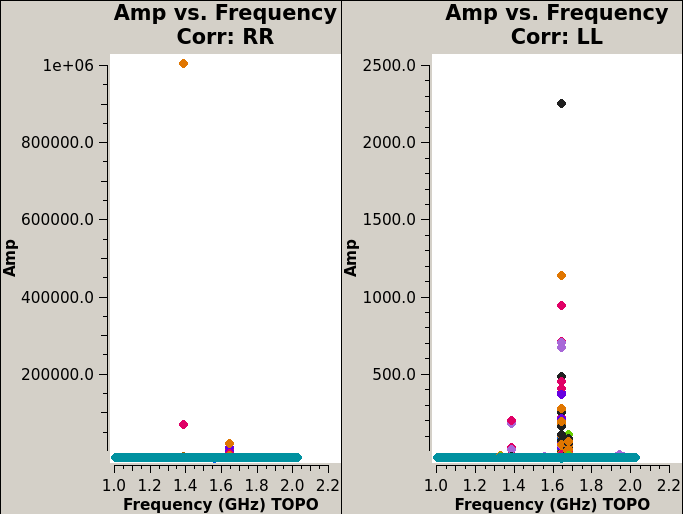

In [87]:
Image(filename=root + "/plots/dataplots/before_targets_round_0_flagging_amp_vs_freq_CorrRR,LL.png")

### After Flagging

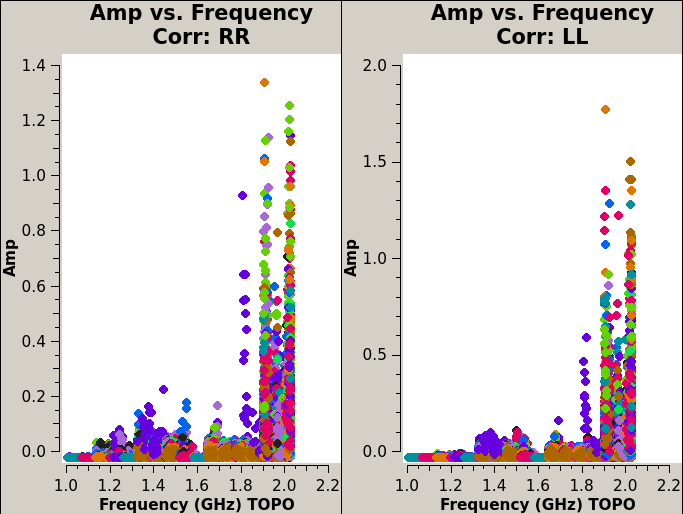

In [88]:
Image(filename=root + "/plots/dataplots/after_targets_round_0_flagging_amp_vs_freq_CorrRR,LL.png")

### Summary

In [75]:
rnd=0
summary_before = np.load(root + f"/output/targets_round_{rnd}_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/targets_round_{rnd}_flags_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) after flagging the flux calibrator:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) after flagging the flux calibrator:

field QSO J1048+4637
Before: 58, After: 59

field QSO J1137+3549
Before: 57, After: 59

scan 4
Before: 58, After: 59

scan 7
Before: 57, After: 59

antenna ea01
Before: 54, After: 56

antenna ea02
Before: 54, After: 56

antenna ea03
Before: 54, After: 55

antenna ea04
Before: 54, After: 55

antenna ea05
Before: 54, After: 55

antenna ea06
Before: 54, After: 55

antenna ea07
Before: 54, After: 55

antenna ea08
Before: 54, After: 57

antenna ea09
Before: 54, After: 55

antenna ea10
Before: 54, After: 56

antenna ea11
Before: 54, After: 55

antenna ea12
Before: 54, After: 56

antenna ea13
Before: 54, After: 56

antenna ea14
Before: 54, After: 55

antenna ea15
Before: 54, After: 55

antenna ea16
Before: 54, After: 55

antenna ea17
Before: 54, After: 55

antenna ea18
Before: 54, After: 55

antenna ea19
Before: 54, After: 55

antenna ea20
Before: 54, After: 55

antenna ea22
Before: 54, After: 56

antenna ea23
Before: 54, After: 56

## Summary Plots
These plots show the corrected amplitudes and phases of all fields as a function of uv-distance and frequency. The values plotted against uv-distance are colorised by spectral window while those plotted against frequency are colorised by antenna number. Remaining RFI should be flagged manually in CASA.

In [76]:
field_dict = vladata.get_field_names(ms)
fields = field_dict["calibrators"] + "," + field_dict["targets"]

J0542+4951


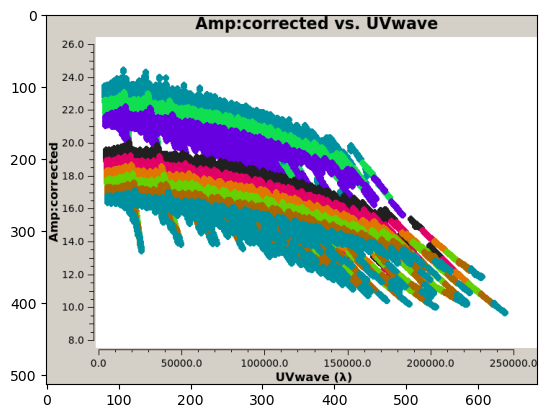

J1033+4116


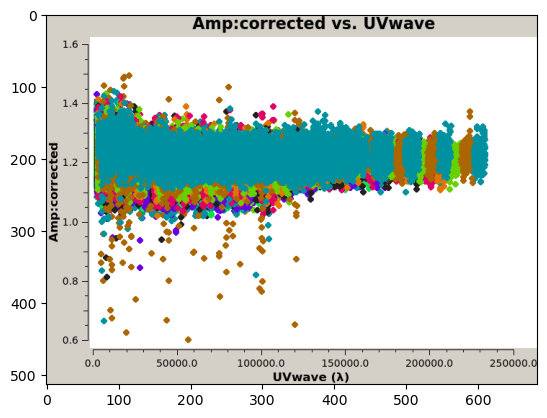

J1130+3815


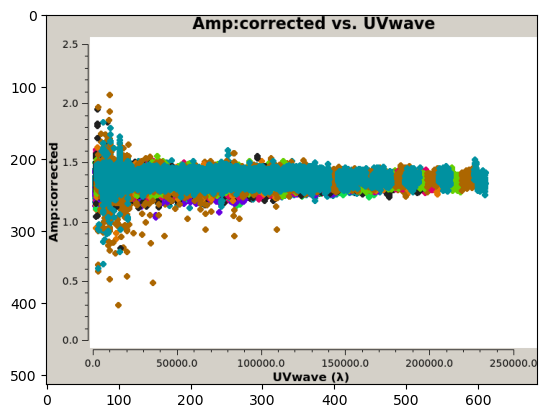

QSO J1048+4637


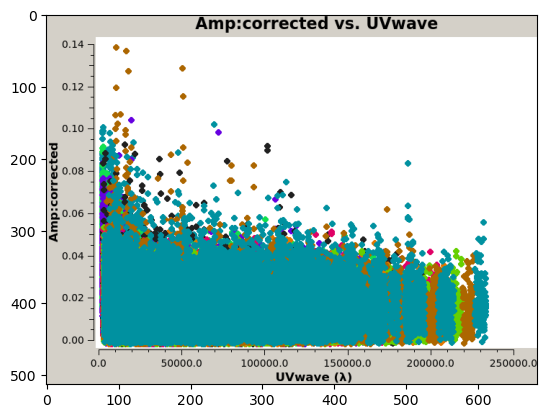

QSO J1137+3549


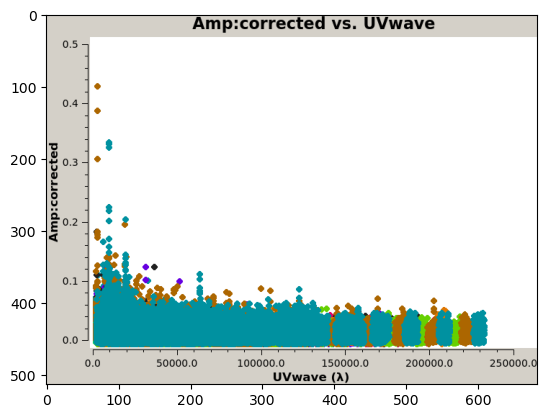

In [77]:
for field in fields.split(","):
    print(field)
    img = mpimg.imread(root + f"/plots/dataplots/{field}_amp_vs_uvdist_corrected.png")
    imgplot = plt.imshow(img)
    plt.show()

J0542+4951


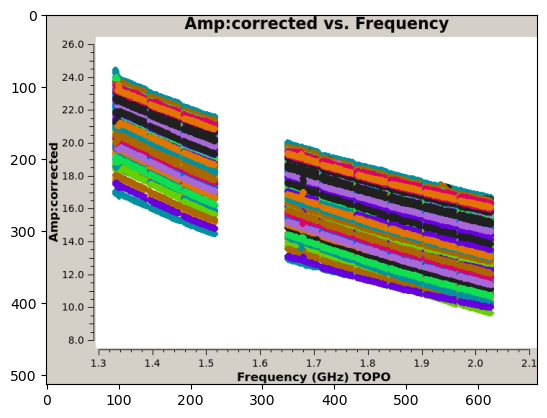

J1033+4116


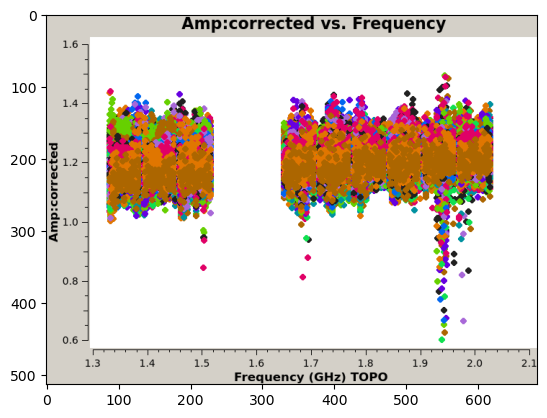

J1130+3815


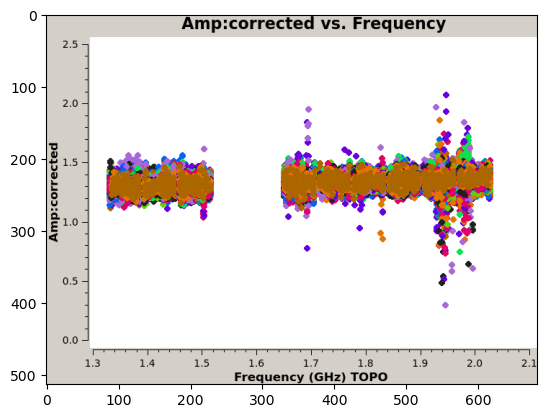

QSO J1048+4637


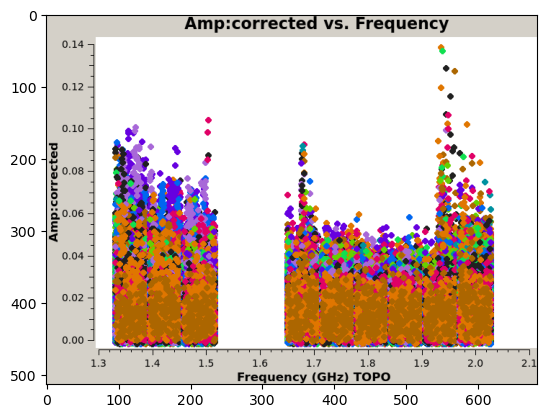

QSO J1137+3549


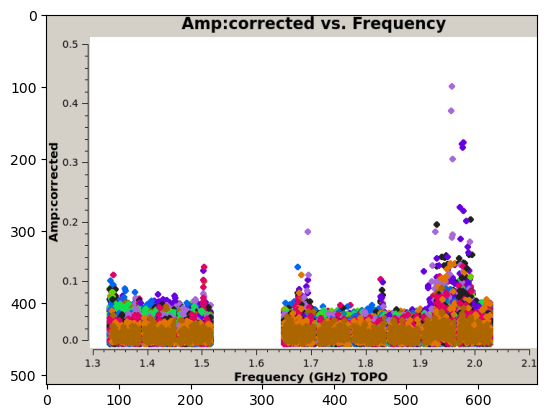

In [78]:
for field in fields.split(","):
    print(field)
    img = mpimg.imread(root + f"/plots/dataplots/{field}_amp_vs_freq_corrected.png")
    imgplot = plt.imshow(img)
    plt.show()

J0542+4951


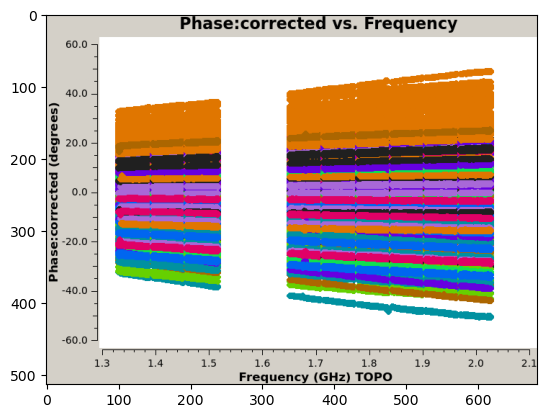

J1033+4116


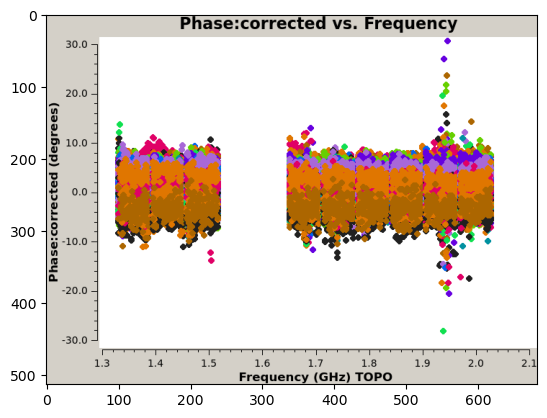

J1130+3815


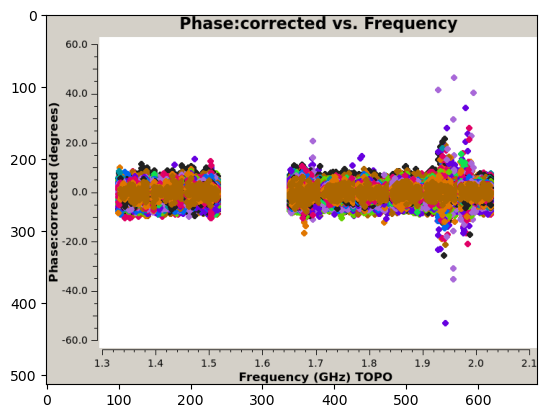

QSO J1048+4637


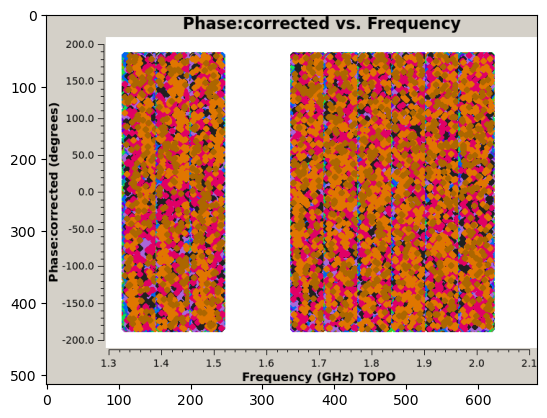

QSO J1137+3549


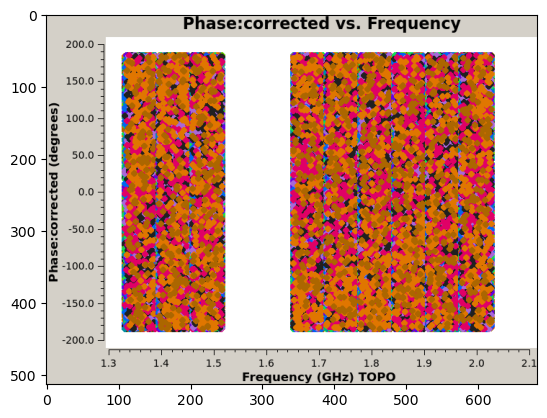

In [79]:
for field in fields.split(","):
    print(field)
    img = mpimg.imread(root + f"/plots/dataplots/{field}_phase_vs_freq_corrected.png")
    imgplot = plt.imshow(img)
    plt.show()

In [82]:

with h5py.File(root + f"/output/z_score_corrected.h5", "r") as f:
    z_score = f["z-score avg"][()]
    flags = f["flags avg"][()]
    freq_array = f["freq array"][()]
    time_array = f["time array"][()]
    ant_pairs = f["ant pairs"][()]
    dt = f["dt"][()]

# Load time integrations per scan
ntimes_file = os.path.join(root, f"output/ntimes.txt")
ntimes = np.loadtxt(ntimes_file).astype(int)

# time array
tisot = np.unique(Time(time_array, format="jd", scale="utc").isot)

z_score = np.ma.masked_array(z_score, mask=flags)

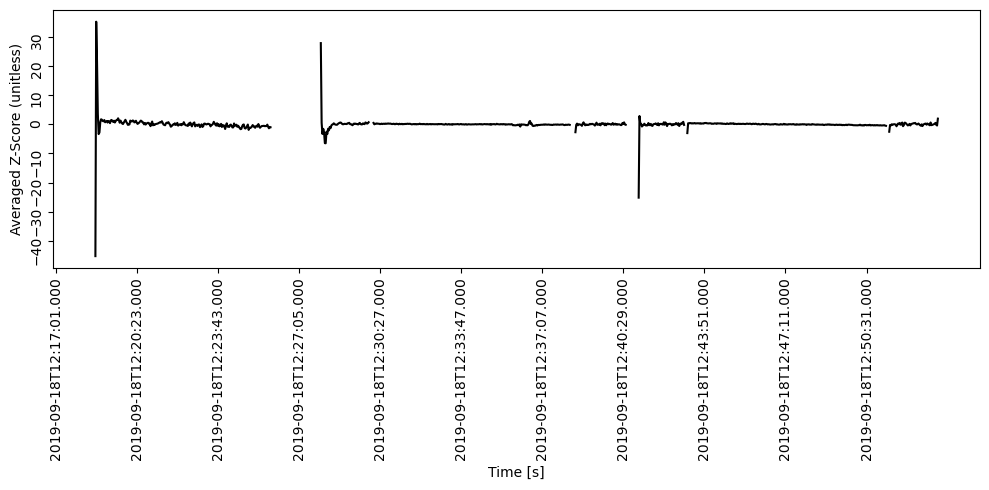

In [83]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=True)
ax = inspect.plot_time_series(tisot, np.ma.median(z_score, axis=1), ax, plot_masked=True)
ax.set_ylabel("Averaged Z-Score (unitless)")
ax.set_xticks(tisot[::100])
plt.tight_layout()

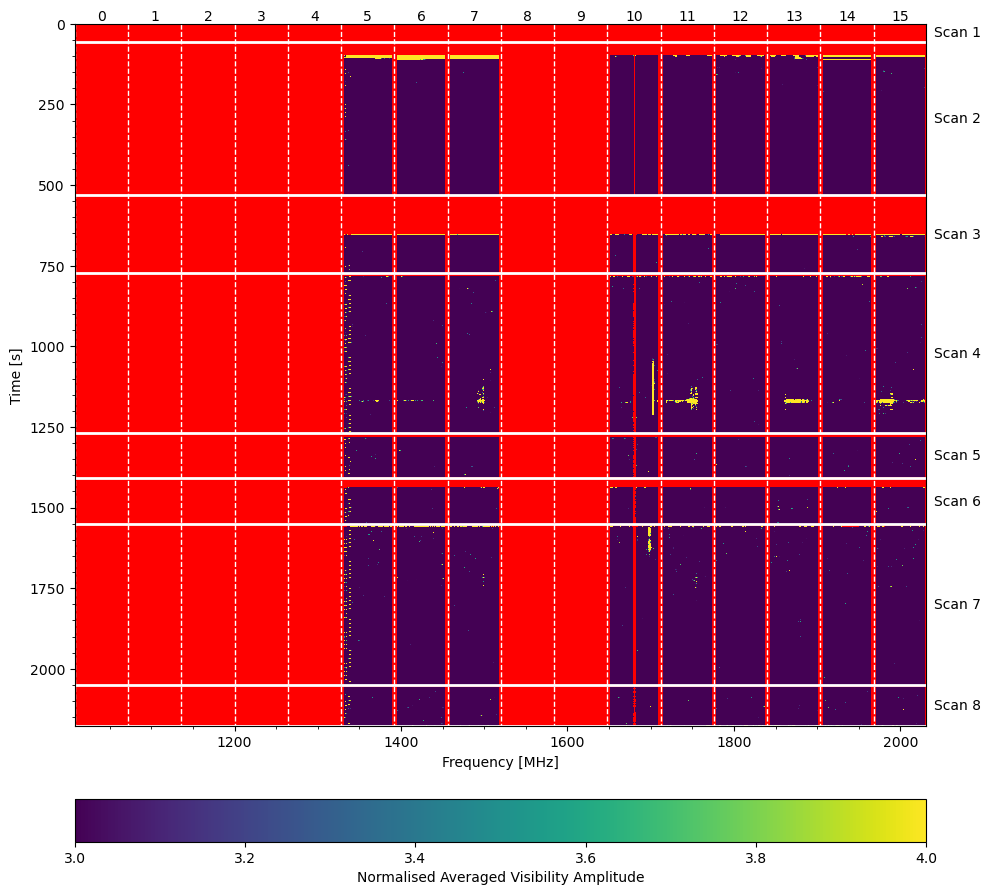

In [92]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))
ax, im = inspect.plot_wf(freq_array, z_score, 2, ntimes, vmin=3, vmax=4, cmap=cmap, ax=ax, plot_masked=True)
fig.colorbar(im, orientation="horizontal", pad=0.08, label="Normalised Averaged Visibility Amplitude")